# ARIMA one step forecast and ACCURACY

In [2]:
import pandas as pd
from sqlalchemy import create_engine
import numpy as np
from sklearn import linear_model
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LinearRegression
from sklearn import metrics
#from sklearn.cross_validation import cross_val_score
#from sklearn.cross_validation import cross_val_predict
import datetime as dt
import matplotlib.pyplot as plt
%matplotlib inline
from alex.database import Database
from pprint import pprint
from statsmodels.tsa.stattools import adfuller # Расширенный тест Дики-Фуллера
from statsmodels.tsa.stattools import acf
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.arima_model import ARIMA, ARMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from pandas.plotting import autocorrelation_plot

### Скоростная загрузка с диска, из заархивированного CSV-файла

In [3]:
# результат выполнения запроса:
# select * from tvf_get_order_book_snapshots(2880) where exchange='binance' and pair='ETH/USDT' # запрос на 20 минут
#order = pd.read_csv('tvf_get_order_book_snapshots 15.09.2018-01.10.2018.zip', index_col='dt')

In [4]:
# загрузка истории
# 15 секунд
db = Database()
sql_history = f"select * from v_history where exchange='binance' and pair='ETH/USDT' and dt>'2018-08-1'"
df_history = db.query(sql_history)
df_history.set_index('dt', inplace=True)

In [5]:
df_history.shape

(4576116, 11)

In [6]:
df_history.sort_values('dt').head()

,rownum,id_ex_pair,exchange,pair,price,amount,type,side,id,location,insert_date
dt,,,,,,,,,,,
2018-08-07 03:18:34,NaN,19,binance,ETH/USDT,406.630005,0.03000,None,buy,NaN,disk,2018-09-07 02:20:10.6200000
2018-08-07 03:18:34,NaN,19,binance,ETH/USDT,406.399994,3.50655,None,sell,NaN,disk,2018-09-07 02:20:10.6200000
2018-08-07 03:18:41,NaN,19,binance,ETH/USDT,406.329987,4.31794,None,sell,NaN,disk,2018-09-07 02:20:10.6200000
2018-08-07 03:18:41,NaN,19,binance,ETH/USDT,406.470001,6.13147,None,buy,NaN,disk,2018-09-07 02:20:10.6200000
2018-08-07 03:18:42,NaN,19,binance,ETH/USDT,406.609985,1.71500,None,buy,NaN,disk,2018-09-07 02:20:10.6200000


In [205]:
#перевод в нужные интервалы
interval = 1 # minutes

#df = history[['price', 'amount']].resample(str(interval)+'min').ohlc()
hist = df_history[['price', 'amount']].resample(str(interval)+'min').mean()
hist.shape

(119162, 2)

In [206]:
hist.fillna(method='ffill', inplace=True)

In [207]:
hist.head()

,price,amount
dt,,
2018-08-07 03:18:00,406.584396,2.071730
2018-08-07 03:19:00,406.469454,1.178643
2018-08-07 03:20:00,406.610001,0.014265
2018-08-07 03:21:00,406.610001,0.014265
2018-08-07 03:22:00,406.610001,0.014265


In [208]:
plt.rcParams['figure.figsize'] = [14, 7]

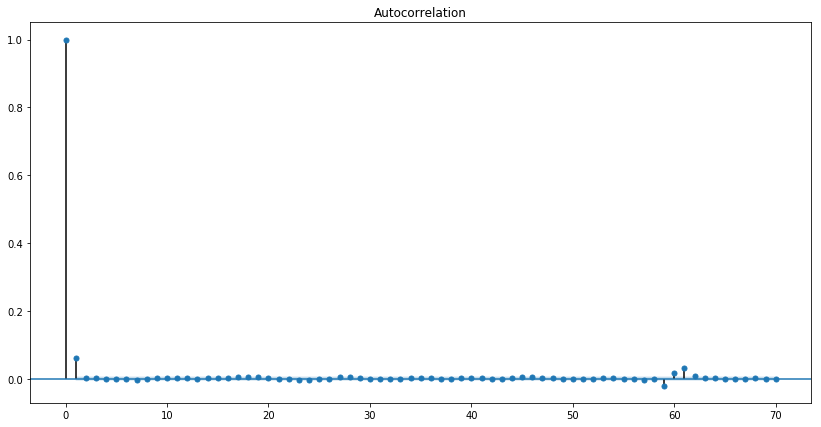

In [209]:
_ = plot_acf(hist[0:len(hist)].price.diff().dropna(), lags=70, alpha=0.05)

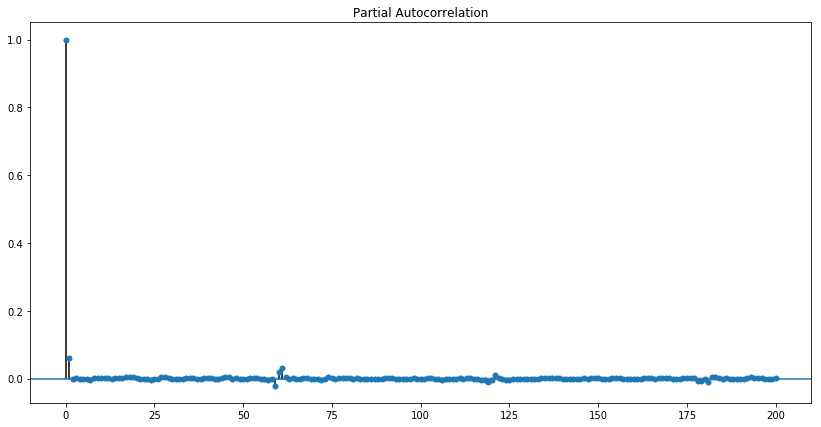

In [210]:
_ = plot_pacf(hist[0:len(hist)].price.diff().dropna(), lags=200, alpha=0.05)

In [211]:
#test-train split
split_coef = 0.75

split_point = int(len(hist)*split_coef)
train, test = hist[0:split_point], hist[split_point:len(hist)]
len(hist), len(train), len(test)

(119162, 89371, 29791)

In [212]:
#выбор параметров pdq - хрен знает как. Есть блокнот cawa_15. Можно менять и смотреть на конечную метрику.

model = ARIMA(train.price, order=(1,1,0))

In [213]:
model_fit = model.fit()

In [214]:
plt.rcParams['figure.figsize'] = [16, 9]

<Figure size 1152x648 with 0 Axes>

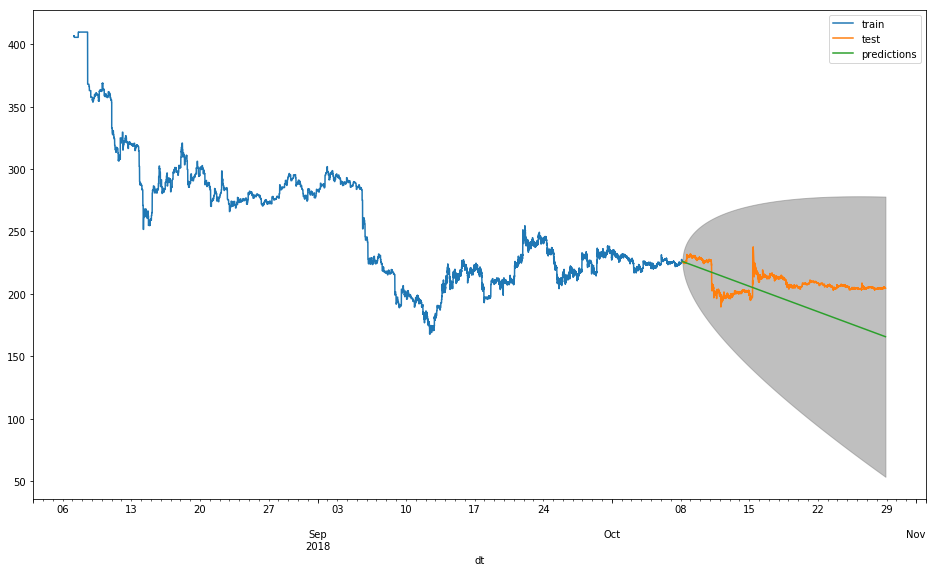

In [215]:
plt.figure()
fig, ax = plt.subplots()

train.price.plot()
test.price.plot(ax=ax)
model_fit.plot_predict(start=len(train), end=len(hist), alpha=0.1, ax=ax)

ax.legend(['train', 'test', 'predictions'])
plt.show()

In [216]:
print(model_fit.summary())

                             ARIMA Model Results                              
Dep. Variable:                D.price   No. Observations:                89370
Model:                 ARIMA(1, 1, 0)   Log Likelihood              -39692.937
Method:                       css-mle   S.D. of innovations              0.377
Date:                Tue, 30 Oct 2018   AIC                          79391.874
Time:                        00:53:56   BIC                          79420.075
Sample:                    08-07-2018   HQIC                         79400.476
                         - 10-08-2018                                         
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const            -0.0020      0.001     -1.529      0.126      -0.005       0.001
ar.L1.D.price     0.0455      0.003     13.602      0.000       0.039       0.052
                                    Root

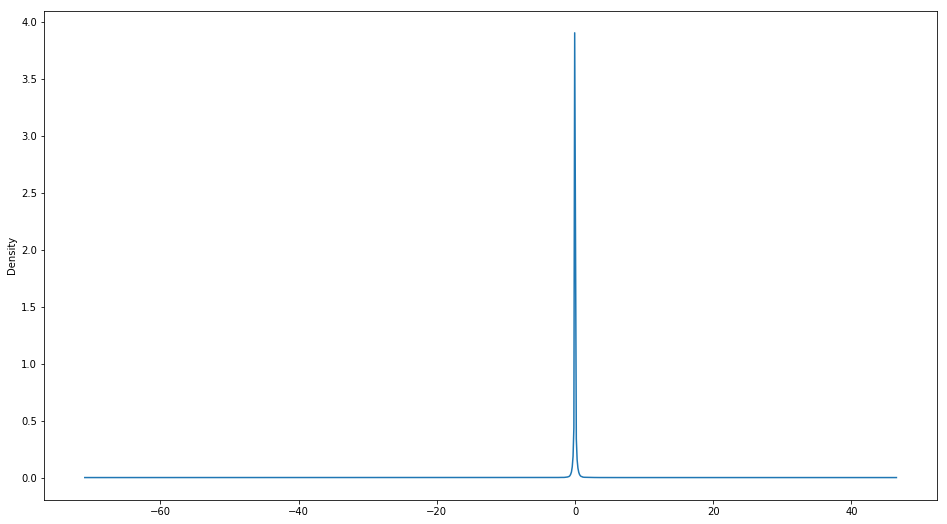

In [217]:
model_fit.resid.plot(kind='kde')

In [218]:
model_fit.resid.describe()

count    8.937000e+04
mean     6.124482e-08
std      3.772711e-01
min     -4.158069e+01
25%      1.929328e-03
50%      1.929328e-03
75%      1.929328e-03
max      1.715074e+01
dtype: float64

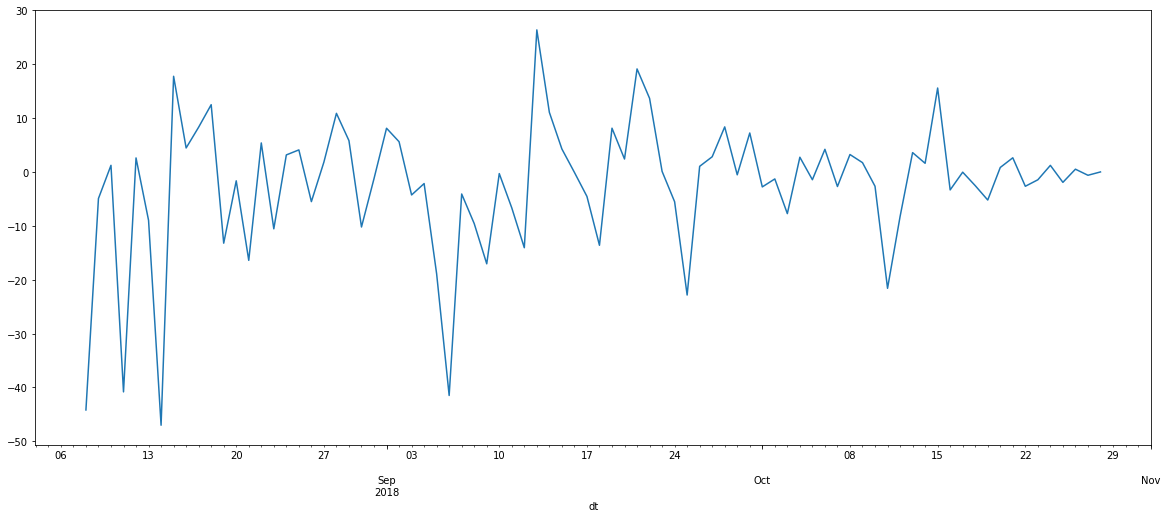

In [219]:
df_history.resample('D').price.mean().diff().plot(figsize=(20,8))

In [220]:
#создание отдельного датафрейма для прогнозов
frcst = pd.DataFrame(model_fit.forecast(steps=len(test))[0], columns=['forecast'])
# добавление в датафрейм временного индекса, который берется из исторической таблицы, начиная с конца трен.выборки и до конца.
frcst['time'] = hist[len(train):].index
frcst.set_index('time', inplace=True)

In [221]:
#объединение датафреймов с фактической историей и прогнозами
hist_frcst = hist.merge(frcst, left_index=True, right_index=True )
#фактический бинарный сигнал о том, что цена поднялась
hist_frcst['IsUp'] = np.where(hist_frcst.price > hist_frcst.price.shift(1), 1, 0)
#сигнал прогноза
hist_frcst['arima_signal'] = np.where(hist_frcst.forecast > hist_frcst.price.shift(1), 1, 0)

In [222]:
hist_frcst['arima_acc'] = np.where(hist_frcst.arima_signal == hist_frcst.IsUp, 1, 0)
arima_accuracy = hist_frcst.arima_acc.sum() / hist_frcst.arima_acc.count()
print ('ARIMA accuracy = ', arima_accuracy)
print ('p =', model_fit.k_trend, ', d =', model_fit.k_diff, ', q =', model_fit.k_ma)
print('выбранный временной интервал =',interval, 'минут')
print('обучающая выборка', len(train), ' - с', train.index[0], ' по', train.index[-1])
print('тестовая выборка', len(test),  ' - с', test.index[0], ' по', test.index[-1])
print('процент выборки под обучение', split_coef)

ARIMA accuracy =  0.5906146151522271
p = 1 , d = 1 , q = 0
выбранный временной интервал = 1 минут
обучающая выборка 89371  - с 2018-08-07 03:18:00  по 2018-10-08 04:48:00
тестовая выборка 29791  - с 2018-10-08 04:49:00  по 2018-10-28 21:19:00
процент выборки под обучение 0.75
